# Data Processing

In [1]:
from pathlib import Path
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

## Parse Results

### Parse Experiment Results from xtb Output Files

In [ ]:
from multiprocessing.dummy import Pool

experiments_path = Path("experiments")
processed_results_path = Path("processed_results")

results_df = pd.DataFrame(
    columns=["molecule", "parameter", "factor", "parameter value", "atomisation energy"]
)

for parameter_path in tqdm(
    experiments_path.glob("*"), total=len(list(experiments_path.glob("*")))
):
    for run_path in parameter_path.glob("*"):
        parameter_factor, parameter_value = run_path.name.split("_")
        for molecule in run_path.glob("*"):
            if not molecule.is_dir():
                continue
            with open(molecule / "stdout.txt") as f:
                output_file = f.readlines()
            for line in output_file:
                if "atomisation energy" not in line:
                    continue
                atomisation_energy = float(re.sub("[^\d.]", "", line))
                results_df.loc[len(results_df)] = [
                    molecule.name,
                    parameter_path.name,
                    parameter_factor,
                    parameter_value,
                    atomisation_energy,
                ]

                break

100%|██████████| 24/24 [24:34<00:00, 61.44s/it] 


In [ ]:
results_df.to_csv(processed_results_path / "parsed_results.csv", index=False)

### Add VQM24 Reference Atomisation Energies

In [5]:
results_df = pd.read_csv("parsed_results.csv")

reference_energies = pd.read_csv("VQM24_atomisation_energies.csv")

In [6]:
results_df["VQM24 atomisation energy"] = 0

for _, row in tqdm(reference_energies.iterrows()):
    molecule, reference_energy = row

    # VQM24 energies are flipped
    reference_energy = -reference_energy

    results_df.loc[results_df["molecule"] == molecule, "VQM24 atomisation energy"] = reference_energy

results_df["error"] = results_df["atomisation energy"] - results_df["VQM24 atomisation energy"]

0it [00:00, ?it/s]

/var/folders/3m/2lzp5b051qd01070jvyf9zw80000gn/T/ipykernel_31972/308037287.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9296842826233842' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_df.loc[results_df["molecule"] == molecule, "VQM24 atomisation energy"] = reference_energy
752it [00:11, 66.13it/s]


In [7]:
results_df.head()

,molecule,parameter,factor,parameter value,atomisation energy,VQM24 atomisation energy,error
0,COSi2SxH4_628,kexplight,0.98,0.98,1.916708,1.120717,0.795991
1,C2PSSiH7_203_conformer_3,kexplight,0.98,0.98,2.527984,0.000000,2.527984
2,CN2OSiH6_140_conformer_17,kexplight,0.98,0.98,2.502939,0.000000,2.502939
3,CNP3H6_24_conformer_3,kexplight,0.98,0.98,2.446487,0.000000,2.446487
4,C2NSi2H7_252_conformer_4,kexplight,0.98,0.98,2.756652,0.000000,2.756652


In [ ]:
results_df.to_csv(processed_results_path / "with_reference_results.csv", index=False)

## Plot

In [2]:
results_df = pd.read_csv("with_reference_results.csv")
results_df.head()

,molecule,parameter,factor,parameter value,atomisation energy,VQM24 atomisation energy,error
0,COSi2SxH4_628,kexplight,0.98,0.98,1.916708,1.120717,0.795991
1,C2PSSiH7_203_conformer_3,kexplight,0.98,0.98,2.527984,0.000000,2.527984
2,CN2OSiH6_140_conformer_17,kexplight,0.98,0.98,2.502939,0.000000,2.502939
3,CNP3H6_24_conformer_3,kexplight,0.98,0.98,2.446487,0.000000,2.446487
4,C2NSi2H7_252_conformer_4,kexplight,0.98,0.98,2.756652,0.000000,2.756652


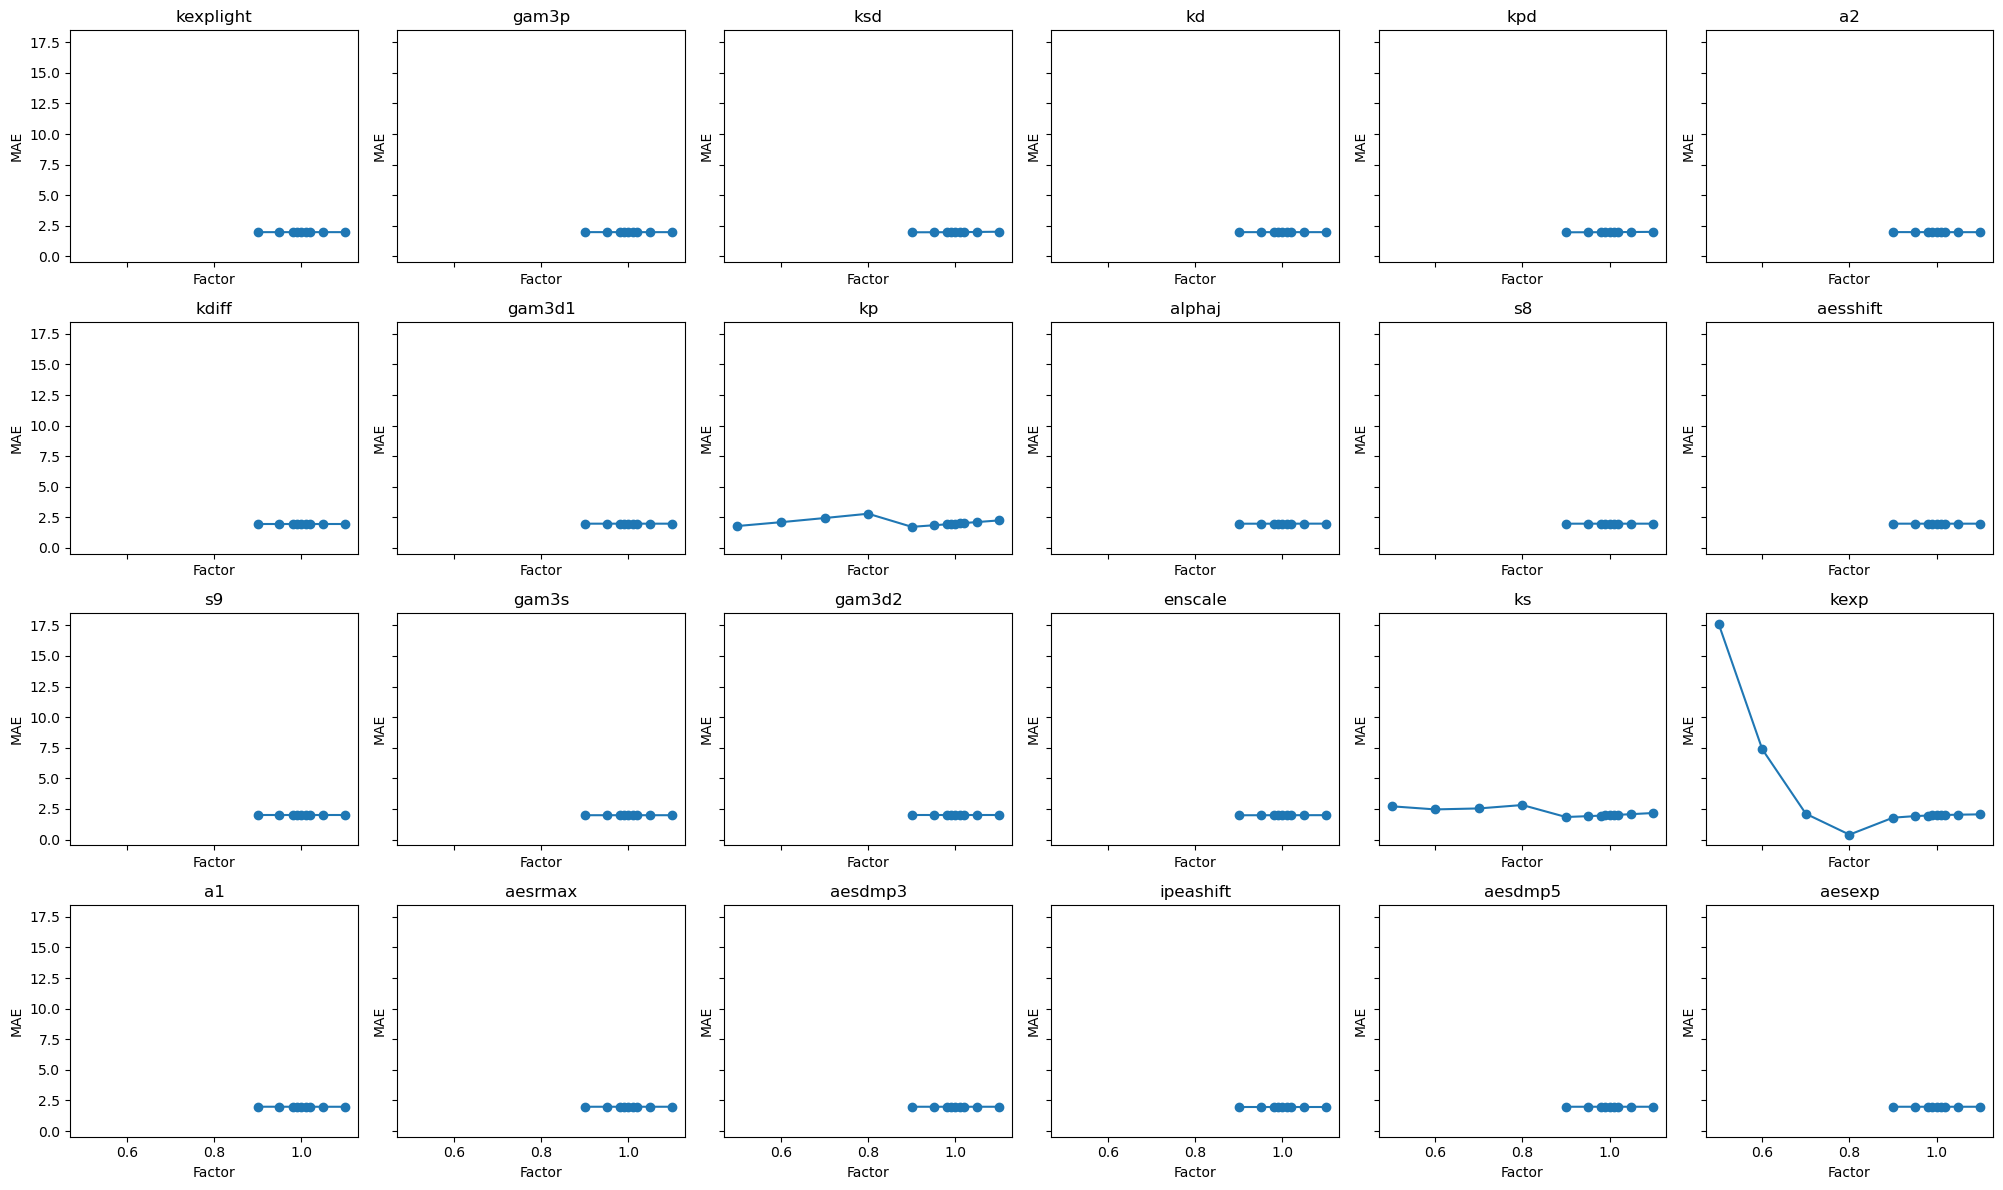

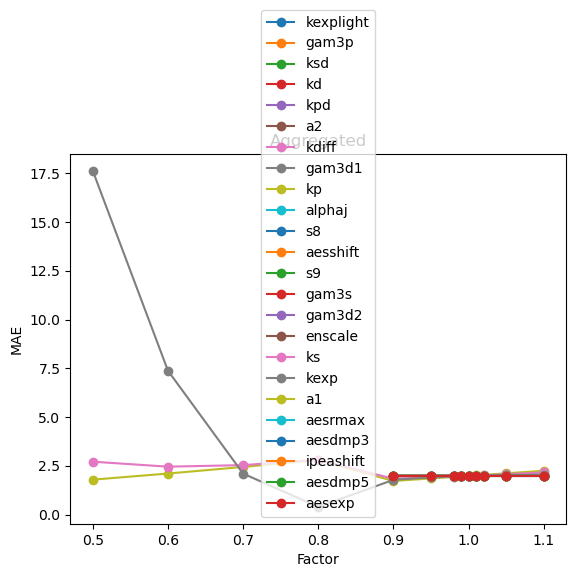

In [12]:
num_rows, num_cols = (4, 6)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey=True)

aggregated_fig, aggregated_axs = plt.subplots()

for i, parameter in enumerate(results_df["parameter"].unique()):
    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]

        errors.append((factor, factor_df["error"].abs().mean()))

    ax = axs[i // num_cols, i % num_cols]

    errors.sort(key=lambda x: x[0])

    ax.plot([x[0] for x in errors], [x[1] for x in errors], marker="o")
    aggregated_axs.plot([x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter)
    
    ax.set_title(parameter)
    ax.set_xlabel("Factor")
    ax.set_ylabel("MAE")

    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("MAE")
    aggregated_axs.legend()

fig.tight_layout()
plt.show()

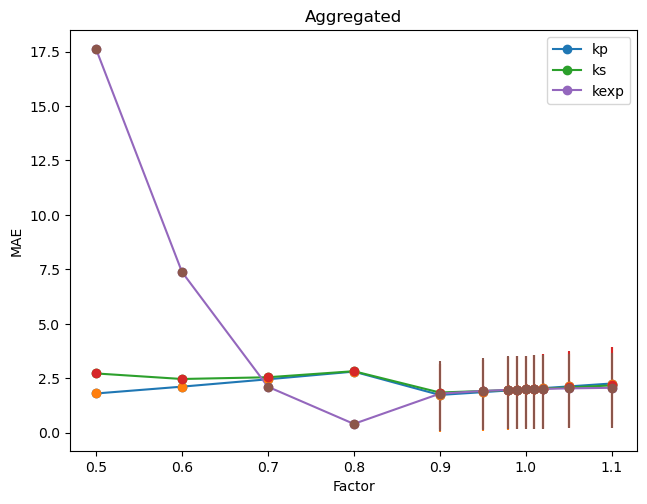

In [4]:
selected_parameters = ['kp', 'ks', 'kexp']

aggregated_fig, aggregated_axs = plt.subplots()
aggregated_fig.tight_layout()

for i, parameter in enumerate(results_df["parameter"].unique()):
    if parameter not in selected_parameters:
        continue

    parameter_df = results_df[results_df["parameter"] == parameter]

    errors = []
    max_errors = []
    min_errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]

        errors.append((factor, factor_df["error"].abs().mean()))
        max_errors.append((factor, factor_df["error"].abs().max() - factor_df["error"].abs().mean()))
        min_errors.append((factor, factor_df["error"].abs().mean() - factor_df["error"].abs().min()))

    errors.sort(key=lambda x: x[0])
    max_errors.sort(key=lambda x: x[0])
    min_errors.sort(key=lambda x: x[0])

    aggregated_axs.plot([x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter)
    aggregated_axs.errorbar([x[0] for x in errors], [x[1] for x in errors], yerr=[[error[1] for error in min_errors],[error[1] for error in max_errors]], fmt='o')
    
    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("MAE")
    aggregated_axs.legend()
plt.show()

## Find Sensitive Molecule

In [5]:
results_df.head()

sensitive_molecules = {}

for parameter in selected_parameters:
    parameter_df = results_df[results_df["parameter"] == parameter]

    diffs = []

    for molecule in parameter_df["molecule"].unique():
        molecule_df = parameter_df[parameter_df["molecule"] == molecule]

        molecule_df.sort_values("factor", inplace=True)

        diffs.append((molecule, molecule_df['error'].diff().abs().mean()))

    diffs.sort(key=lambda x: x[1], reverse=True)

    sensitive_molecules[parameter] = diffs[0]

sensitive_molecules

/var/folders/3m/2lzp5b051qd01070jvyf9zw80000gn/T/ipykernel_50572/2419524912.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molecule_df.sort_values("factor", inplace=True)


{'kp': ('C3NSiH11_21_conformer_6', np.float64(0.17628983607033333)),
 'ks': ('C3NSiH11_21_conformer_6', np.float64(0.1433819938795)),
 'kexp': ('CNSSi2H3_119_conformer_1', np.float64(1.5714546978547501))}

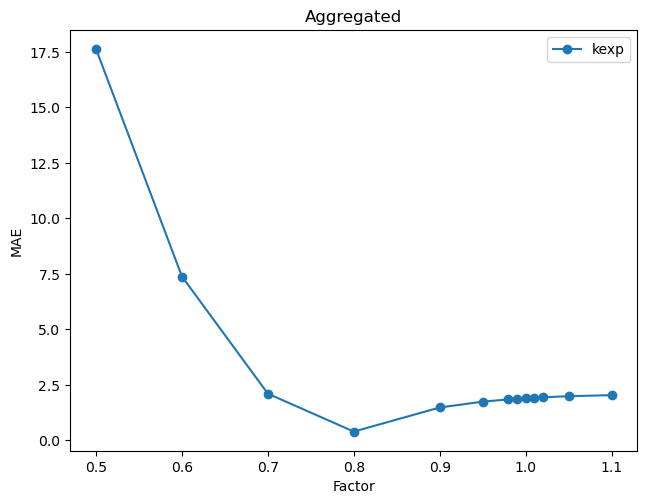

In [6]:
selected_parameters = ['kexp']

aggregated_fig, aggregated_axs = plt.subplots()
aggregated_fig.tight_layout()

for i, parameter in enumerate(selected_parameters):
    parameter_df = results_df[results_df["parameter"] == parameter]

    parameter_df = parameter_df[parameter_df["molecule"] == sensitive_molecules[parameter][0]]

    errors = []
    max_errors = []
    min_errors = []
    for j, factor in enumerate(parameter_df["factor"].unique()):
        factor_df = parameter_df[parameter_df["factor"] == factor]

        errors.append((factor, factor_df["error"].abs().mean()))

    errors.sort(key=lambda x: x[0])

    aggregated_axs.plot([x[0] for x in errors], [x[1] for x in errors], marker="o", label=parameter)
    
    aggregated_axs.set_title("Aggregated")
    aggregated_axs.set_xlabel("Factor")
    aggregated_axs.set_ylabel("MAE")
    aggregated_axs.legend()
plt.show()

In [7]:
errors

[(np.float64(0.5), np.float64(17.615090850796)),
 (np.float64(0.6), np.float64(7.376862860939)),
 (np.float64(0.7), np.float64(2.104968816018)),
 (np.float64(0.8), np.float64(0.398611680015)),
 (np.float64(0.9), np.float64(1.484196534613)),
 (np.float64(0.95), np.float64(1.745555506208)),
 (np.float64(0.98), np.float64(1.848743012726)),
 (np.float64(0.99), np.float64(1.876370885443)),
 (np.float64(1.0), np.float64(1.901115291022)),
 (np.float64(1.01), np.float64(1.923243704226)),
 (np.float64(1.02), np.float64(1.943003282183)),
 (np.float64(1.05), np.float64(1.990258335482)),
 (np.float64(1.1), np.float64(2.039588883491))]